# Training a skip-gram (word2vec) model on a small TED talk corpus

### Prerequisites: pandas, a couple sklearn modules, nltk, plotnine, and UMAP

In [1]:
import pandas as pd
import numpy as np
from umap import UMAP
from plotnine import *
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

### Load in the data using pandas.

Each row corresponds to one observation, roughly a sentence long.

There are three columns to the data: 

* file_id (which talk it comes from)
* chunk_id (which segment of the file)
* chunk_text (a short utterance)

In [2]:
df = pd.read_csv('./ted_en-20160408_full.txt', sep="\t")
print(df.sort_values(['file_id', 'chunk_id']).head())

   Unnamed: 0  file_id  chunk_id  \
0           0        1         0   
1           1        1         1   
2           2        1         2   
3           3        1         3   
4           4        1         4   

                                          chunk_text  
0               Here are two reasons companies fail:  
1                     they only do more of the same,  
2                        or they only do what's new.  
3    To me the real, real solution to quality growth  
4  is figuring out the balance between two activi...  


### Implementing LSA for a standard corpus of English requires a few transformations:

1. Set up the `CountVectorizer` using `word_tokenize` -- turns each line into a bag-of-words representation
2. Determine whether you want your text lowercase or not (to treat THIS, ThiS, and thiS as equals) - `CountVectorizer` assumes you want to do this.
3. Select a few major parameters:
    * What do you want the minimum number of observations of a word to be? (`CountVectorizer`'s `min_df`)
    * How many dimensions do you want the word vectors to have (`TruncatedSVD`'s `n_components`)?

In [3]:
n_dims = 100
min_df = 1

pca = TruncatedSVD(n_components=n_dims)
cv = CountVectorizer(min_df=min_df, tokenizer=word_tokenize)

### Obtaining the bag-of-words, run dimensionality reduction on it to get word vectors

In [4]:
bag_of_words = cv.fit_transform(df['chunk_text'])

In [5]:
vecs = pca.fit_transform(bag_of_words)

### Inspecting the learned representations

0. Store the vectors in an easy-to-view format (e.g. a data frame)
1. Make sure the representations make sense -- e.g. simple tests with common words
2. Visualize it

In [6]:
vector_df = pd.DataFrame(pca.components_.T, index=cv.get_feature_names())
normalized_vector_df = vector_df / np.c_[np.sqrt((vector_df ** 2))]

In [7]:
def most_similar(vector_df, word, top_n=10):
    return vector_df.dot(vector_df.loc[word]).sort_values(ascending=False).head(top_n) / 100

In [8]:
print(most_similar(normalized_vector_df, 'red'))
print(most_similar(normalized_vector_df, 'explore'))

red           1.00
yellow        0.64
blue          0.54
green         0.48
cervix        0.46
dark          0.46
trapezoids    0.46
vertical      0.46
calving       0.46
pore          0.44
dtype: float64
explore        1.00
roadrunner     0.48
navigate       0.48
adapt          0.48
tussauds       0.46
lead           0.46
conquer        0.46
kempton        0.46
conceivable    0.44
develop        0.44
dtype: float64


## Visualization

There are a number of choices we could make here (t-SNE, UMAP, hierarchical clustering). It is common to use t-SNE for visualization but it can be slow. Instead, we will use UMAP.

In [9]:
umap = UMAP()
umap_vectors = umap.fit_transform(vector_df)
umap_df = pd.DataFrame(umap_vectors,
                       index=vector_df.index.values,
                       columns=['umap_x', 'umap_y'])

/Users/constantine/Documents/academic/ferreira_lab/independent_papers/buckeye_elmo/elmotest/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


### As with any embedding method we can now visualize the semantic space somewhat

We will do this in UMAP (even though e.g. t-SNE is the most common package) simply because UMAP is much faster.

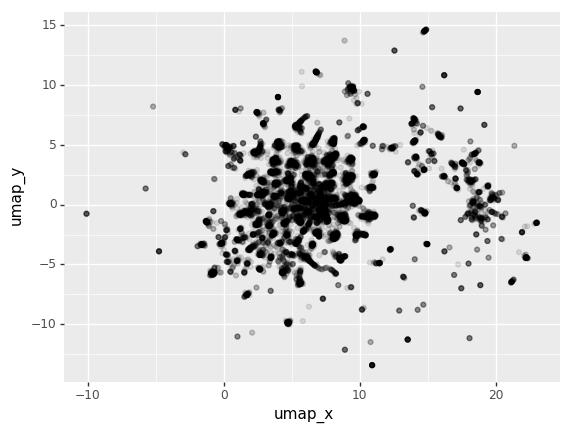

<ggplot: (-9223372036539685779)>

In [10]:
ggplot(umap_df[umap_df['umap_x']>-25].sample(frac=0.2), aes('umap_x', 'umap_y')) + geom_point(alpha=0.1)